In [1]:
import collections
import gzip
import json
import os
import re
import string
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import editdistance
from Bio import pairwise2

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [21]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20230717')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20230717')
DIR_REF = os.path.join(DIR_PROJECT, 'data_ref')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20230717')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)

In [3]:
n_threads = 10

# Code Setup

In [4]:
from contextlib import AbstractContextManager

class BashRunnerWithSharedEnvironment(AbstractContextManager):
    """
    Run multiple bash scripts with persisent environment.
    Environment is stored to "env" member between runs. This can be updated
    directly to adjust the environment, or read to get variables.
    """

    def __init__(self, env=None):
        if env is None:
            env = dict(os.environ)
        self.env: Dict[str, str] = env
        self._fd_read, self._fd_write = os.pipe()

    def run(self, cmd, **opts):
        if self._fd_read is None:
            raise RuntimeError("BashRunner is already closed")
        write_env_pycode = ";".join(
            [
                "import os",
                "import json",
                f"os.write({self._fd_write}, json.dumps(dict(os.environ)).encode())",
            ]
        )
        write_env_shell_cmd = f"{sys.executable} -c '{write_env_pycode}'"
        cmd += "\n" + write_env_shell_cmd
        result = subprocess.run(
            ["bash", "-ce", cmd], pass_fds=[self._fd_write], env=self.env, **opts
        )
        self.env = json.loads(os.read(self._fd_read, 50000).decode())
        return result

    def __exit__(self, exc_type, exc_value, traceback):
        if self._fd_read:
            os.close(self._fd_read)
            os.close(self._fd_write)
            self._fd_read = None
            self._fd_write = None

    def __del__(self):
        self.__exit__(None, None, None)

In [5]:
def fastq_parse(fp):
    """
    Parse fastq file.
    """
    linecount = 0
    name, seq, thrd, qual = [None] * 4
    for line in fp:
        linecount += 1
        try:
            line_stripped = line.decode("UTF-8").rstrip()
        except AttributeError:
            line_stripped = line.rstrip()
        if linecount % 4 == 1:
            name = line_stripped
            assert name.startswith("@")
        elif linecount % 4 == 2:
            seq = line_stripped
        elif linecount % 4 == 3:
            thrd = line_stripped
            assert thrd.startswith("+")
        elif linecount % 4 == 0:
            qual = line_stripped
            assert len(seq) == len(qual)
            yield name, seq, thrd, qual
            name, seq, thrd, qual = [None] * 4

In [6]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

In [7]:
sprite_env = BashRunnerWithSharedEnvironment()
sprite_env.run('source ~/.bashrc; conda activate sprite')

CompletedProcess(args=['bash', '-ce', "source ~/.bashrc; conda activate sprite\n/home/btyeh/miniconda3/envs/py3/bin/python -c 'import os;import json;os.write(59, json.dumps(dict(os.environ)).encode())'"], returncode=0)

# Data

In [8]:
regex_fastq_files = re.compile('(?P<filename>(?P<sample>(?P<cell_count>^.*)cell_aliquot(?P<aliquot>[^_]+)_(?P<band>barcode|150bp))_.*R(?P<read>1|2)_001.fastq.gz)')

In [9]:
df_data = pd.DataFrame([regex_fastq_files.match(file).groupdict() for file in os.listdir(DIR_DATA)])
df_data['cell_count'] = df_data['cell_count'].str.replace('-', '.').astype(float)
df_data['read'] = df_data['read'].astype(int)

In [10]:
popen_counts = dict()
for sample, group in df_data.groupby('sample'):
    filename = group.loc[group['read'] == 1, 'filename'].item()
    cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
    popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)

In [11]:
df_data['n_reads'] = 0
for sample, popen in popen_counts.items():
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())

In [12]:
df_data = df_data.sort_values(['cell_count', 'aliquot', 'read'])
df_data

,filename,sample,cell_count,aliquot,band,read,n_reads
8,0-15625cell_aliquot1_150bp_S3_L001_R1_001.fast...,0-15625cell_aliquot1_150bp,0.15625,1,150bp,1,159327
2,0-15625cell_aliquot1_150bp_S3_L001_R2_001.fast...,0-15625cell_aliquot1_150bp,0.15625,1,150bp,2,159327
5,0-5cell_aliquotA6_barcode_S4_L001_R1_001.fastq.gz,0-5cell_aliquotA6_barcode,0.50000,A6,barcode,1,2651
6,0-5cell_aliquotA6_barcode_S4_L001_R2_001.fastq.gz,0-5cell_aliquotA6_barcode,0.50000,A6,barcode,2,2651
1,0-5cell_aliquotE9_barcode_S5_L001_R1_001.fastq.gz,0-5cell_aliquotE9_barcode,0.50000,E9,barcode,1,11121
7,0-5cell_aliquotE9_barcode_S5_L001_R2_001.fastq.gz,0-5cell_aliquotE9_barcode,0.50000,E9,barcode,2,11121
3,0-625cell_aliquot3_barcode_S2_L001_R1_001.fast...,0-625cell_aliquot3_barcode,0.62500,3,barcode,1,42984
9,0-625cell_aliquot3_barcode_S2_L001_R2_001.fast...,0-625cell_aliquot3_barcode,0.62500,3,barcode,2,42984
0,10cell_aliquot1_barcode_S1_L001_R1_001.fastq.gz,10cell_aliquot1_barcode,10.00000,1,barcode,1,4441223
4,10cell_aliquot1_barcode_S1_L001_R2_001.fastq.gz,10cell_aliquot1_barcode,10.00000,1,barcode,2,4441223


# FastQC

In [13]:
dir_fastqc = os.path.join(DIR_PROC, 'fastqc')
os.makedirs(dir_fastqc, exist_ok=True)

In [14]:
paths_fastq_raw = []
for filename in df_data['filename']:
    path_fastqc = os.path.join(dir_fastqc, filename.replace('.fastq.gz', '_fastqc.html'))
    if not os.path.exists(path_fastqc):
        paths_fastq_raw.append(os.path.join(DIR_DATA, filename))
if len(paths_fastq_raw) > 0:
    paths_fastq_raw = ' '.join((f'"{s}"' for s in paths_fastq_raw))
    sprite_env.run(f'fastqc {paths_fastq_raw} -o {dir_fastqc} -t {n_threads}')

# Merge read 1 and read 2

Strategy: merge read 1 and read 2 --> splitcode on merged reads

Alternative strategy (not implemented): (optional) adapter trim --> splitcode on read 1 and read 2

In [15]:
cmd_merge = (
    'NGmerge -1 {path_read1} -2 {path_read2} -o {path_merged} -f {path_failed}'
    ' -d -e 20 -z'
    ' -l {path_log_stich}'
    ' -c {path_log_dovetail}'
    ' -j {path_log_alignment}'
    ' -n {n_threads}')

In [16]:
dir_merged = os.path.join(DIR_PROC, 'merged')
os.makedirs(dir_merged, exist_ok=True)

In [17]:
n_threads = 10
for sample, group in df_data.groupby('sample'):
    path_merged = os.path.join(dir_merged, f'{sample}.fastq.gz')
    if not os.path.exists(path_merged):
        path_read1 = os.path.join(DIR_DATA, group.loc[group['read'] == 1, 'filename'].item())
        path_read2 = os.path.join(DIR_DATA, group.loc[group['read'] == 2, 'filename'].item())
        path_failed = os.path.join(dir_merged, f'{sample}_failed')
        path_log_stich = os.path.join(dir_merged, f'{sample}.stitch.log')
        path_log_dovetail = os.path.join(dir_merged, f'{sample}.dovetail.log')
        path_log_alignment = os.path.join(dir_merged, f'{sample}.alignment.log')
        cmd_run = cmd_merge.format(
            path_read1=path_read1,
            path_read2=path_read2,
            path_merged=path_merged,
            path_failed=path_failed,
            path_log_stich=path_log_stich,
            path_log_dovetail=path_log_dovetail,
            path_log_alignment=path_log_alignment,
            n_threads=n_threads)
        subprocess.run(cmd_run, shell=True)

Run FASTQC on merged FASTQ files

In [18]:
paths_fastq_merged = []
for sample in df_data['sample'].unique():
    path_merged_fastqc = os.path.join(dir_merged, f'{sample}_fastqc.html')
    if not os.path.exists(path_merged_fastqc):
        paths_fastq_merged.append(os.path.join(dir_merged, f'{sample}.fastq.gz'))
if len(paths_fastq_merged) > 0:
    paths_fastq_merged = ' '.join((f'"{s}"' for s in paths_fastq_merged))
    sprite_env.run(f'fastqc {paths_fastq_merged} -o {dir_merged} -t {n_threads}')

# Barcode Identification

## Create config file

- `spritezero_tags.csv` generated from Mario's Google Sheet [scRNAbarcodeBot](https://docs.google.com/spreadsheets/d/1ucpUbArWQl1EUA2CRq7o9Zhc-kuE72fn/) via my Google Colab notebook [SPRITE Zero Tags Config](https://colab.research.google.com/drive/1O8EIRJz3x6inn1-K9bzOYOjfQcMsnPfh)
- `sprite_tags.csv`

Experimental Notes
- R2: did not have cells in wells D9-D12
- R3: did not have cells nor barcode in wells F10-F12
- NY ligates odd: rows C+D; did not have cells nor barcodes for barcodes D11-D12

See [expected library barcode structure](https://benchling.com/s/seq-T9t12cM5vSMuNkk1PUH1) (and [reverse complement](https://benchling.com/s/seq-CUVIraYbDqaaljL0CPZf)) on Benchling

In [19]:
path_config = os.path.join(DIR_AUX, 'splitcode-config.txt')

In [20]:
df_oligos = pd.DataFrame({
    'groups': 'oligo',
    'ids': ('PC50_8merUMI_bc2_odd_sticky', 'PC50_8merUMI_bc3_odd_sticky', 'PC50_8merUMI_bc4_odd_sticky', 'PC50_8merUMI_bc5_odd_sticky'),
    'tags': ('TAGCTACCTT', 'CCTTGAGAG', 'CCACCGAAT', 'CATCAGTTGT')})
df_oligos['tags'] = df_oligos['tags'].map(reverse_complement)

In [21]:
df_sprite = pd.read_csv(os.path.join(DIR_REF, 'sprite_tags.csv'))
df_sprite = df_sprite \
    .loc[(df_sprite['Plate'] == 'NYLigOddStgTop') &
         (df_sprite['Well'].str.match('(C|D)\d+')) &
         ~df_sprite['Well'].isin(('D11', 'D12'))] \
    .rename(columns={'Plate': 'groups', 'Name': 'ids', 'Unique Sequence': 'tags'}) \
    [['groups', 'ids', 'tags']]

In [22]:
df_spritezero = pd.read_csv(os.path.join(DIR_AUX, 'spritezero_tags.csv'))
df_spritezero = df_spritezero.loc[df_spritezero['Orientation'] == 'Top'].rename(
    columns={'Plate': 'groups', 'Name': 'ids', 'Unique Sequence': 'tags'}) \
    [['groups', 'ids', 'tags']]

In [23]:
df_spacer = pd.DataFrame({'groups': ('spacer',), 'ids': ('odd',), 'tags': ('CAAGTCA',)})

In [24]:
df_config = pd.concat((df_oligos, df_spritezero, df_sprite, df_spacer), axis=0, ignore_index=True)

In [25]:
df_config['distances'] = 1
df_config['minFindsG'] = 1
df_config['maxFindsG'] = 1

In [26]:
df_config['next'] = '-'
df_config.loc[df_config['groups'] == 'oligo', 'next'] = '{{spacer}}8-8'
df_config.loc[df_config['groups'] == 'spacer', 'next'] = '{{R1Top}}0-0'
df_config.loc[df_config['groups'] == 'R1Top', 'next'] = '{{R2Top}}5-9'
df_config.loc[df_config['groups'] == 'R2Top', 'next'] = '{{R3Top}}5-9'
df_config.loc[df_config['groups'] == 'R3Top', 'next'] = '{{NYLigOddStgTop}}5-9'

In [27]:
df_config['locations'] = '0:0'
df_config.loc[df_config['groups'] == 'oligo', 'locations'] = '0:0:10'
df_config.loc[df_config['groups'] == 'spacer', 'locations'] = '0:16:25'
df_config.loc[df_config['groups'] == 'R1Top', 'locations'] = '0:23:45'
df_config.loc[df_config['groups'] == 'R2Top', 'locations'] = '0:45:65'
df_config.loc[df_config['groups'] == 'R3Top', 'locations'] = '0:65:88'
df_config.loc[df_config['groups'] == 'NYLigOddStgTop', 'locations'] = '0:88:0'

In [28]:
extraction_header = '@extract <umi{{oligo}}>,{{oligo}}<umi[8]>{{spacer}}'

In [29]:
if not os.path.exists(path_config):
    with open(path_config, 'wt') as f:
        f.write(extraction_header + '\n')
        df_config.to_csv(f, sep='\t', index=False)

## Splitcode

Add barcode and UMI to read name:

`@read::[oligo][spacer][R1Top][R2Top][R3Top][NYLigOddStg] RX:Z:<oligo barcode + UMI>`

In [16]:
dir_barcodes = os.path.join(DIR_PROC, 'barcodes')
os.makedirs(dir_barcodes, exist_ok=True)

In [31]:
cmd_splitcode = (
    f'splitcode -c {path_config} --nFastqs=1 --assign --x-names --mod-names –-no-x-out'
    ' -o {path_output}'
    ' -u {path_unassigned}'
    ' -m {path_mapping}'
    ' -s {path_summary}'
    ' {path_input}')

In [32]:
for sample in df_data['sample'].unique():
    path_output = os.path.join(dir_barcodes, f'{sample}.fastq.gz')
    if not os.path.exists(path_output):
        path_input = os.path.join(dir_merged, f'{sample}.fastq.gz')
        path_output = os.path.join(dir_barcodes, f'{sample}.fastq.gz')
        path_unassigned = os.path.join(dir_barcodes, f'{sample}_unassigned.fastq.gz')
        path_summary = os.path.join(dir_barcodes, f'{sample}.summary')
        path_mapping = os.path.join(dir_barcodes, f'{sample}.mapping')
        cmd_run = cmd_splitcode.format(
            path_output=path_output,
            path_unassigned=path_unassigned,
            path_summary=path_summary,
            path_mapping=path_mapping,
            path_input=path_input)
        print(sample)
        subprocess.run(cmd_run, shell=True)

# Clusters

Here, "cluster" refers to a set of reads with the same barcode (R1-R3 + Y).

The `all_clusters` dictionary is structured as follows:
- key: sample
  - key: barcode / cluster, presumably corresponding to individual cells
    - key: UMI (oligo ID + oligo UMI) - the number of such UMIs per cluster gives the "deduplicated" count of "cluster size" (the number of oligos per cluster (cell))
    - value: number of reads

In [13]:
dir_clusters = os.path.join(DIR_PROC, 'clusters')
os.makedirs(dir_clusters, exist_ok=True)

In [14]:
regex_readname = re.compile('::\[[^\]]+\]\[odd\](' + 4 * '\[[^\]]+\]' + ') RX:Z:([ATCG]+)')

In [17]:
all_clusters = dict()
for sample in df_data['sample'].unique():
    print(sample)
    path_barcoded = os.path.join(dir_barcodes, f'{sample}.fastq.gz')
    path_clusters = os.path.join(dir_clusters, f'{sample}.json')
    if not os.path.exists(path_clusters) or True:
        clusters = dict()
        with gzip.open(path_barcoded) as f:
            for (name, seq, _, qual) in tqdm(fastq_parse(f)):
                match = regex_readname.search(name.strip())
                if match:
                    barcode, umi = match.groups()
                    if barcode not in clusters:
                        clusters[barcode] = collections.defaultdict(int)
                    clusters[barcode][umi] += 1
        with open(path_clusters, 'wt') as f:
            json.dump(clusters, f)
    else:
        with open(path_clusters, 'rt') as f:
            clusters = json.load(f)
    all_clusters[sample] = clusters

0-15625cell_aliquot1_150bp


0it [00:00, ?it/s]

0-5cell_aliquotA6_barcode


0it [00:00, ?it/s]

0-5cell_aliquotE9_barcode


0it [00:00, ?it/s]

0-625cell_aliquot3_barcode


0it [00:00, ?it/s]

10cell_aliquot1_barcode


0it [00:00, ?it/s]

## Cluster statistics

1. Distribution of cluster size (without deduplicating UMIs)
2. Distribution of cluster size (after deduplicating UMIs)
3. In putative cell clusters, duplicate rate of UMIs and number of unique UMIs

In [18]:
cluster_stats = dict()

In [19]:
for sample, clusters in all_clusters.items():
    cluster_stats[sample] = dict()
    cluster_stats[sample]['cluster_sizes_dedup'] = np.array(list(map(len, clusters.values())))
    cluster_stats[sample]['cluster_sizes'] = np.array([sum(cluster.values()) for cluster in clusters.values()])
    print(sample)
    print('Number of clusters:', len(cluster_stats[sample]['cluster_sizes']))
    print('Size of largest clusters:', np.sort(cluster_stats[sample]['cluster_sizes'])[-1:-10:-1])
    print('Size of largest clusters (dedup):', np.sort(cluster_stats[sample]['cluster_sizes_dedup'])[-1:-10:-1])
    print()

0-15625cell_aliquot1_150bp
Number of clusters: 44
Size of largest clusters: [3 3 2 2 1 1 1 1 1]
Size of largest clusters (dedup): [3 3 2 1 1 1 1 1 1]

0-5cell_aliquotA6_barcode
Number of clusters: 429
Size of largest clusters: [557 154  65  65  58  48  48  48  35]
Size of largest clusters (dedup): [557 154  65  64  58  48  48  48  35]

0-5cell_aliquotE9_barcode
Number of clusters: 2947
Size of largest clusters: [201 179 149 133 131 128 122 113 110]
Size of largest clusters (dedup): [201 179 149 133 130 126 121 113 110]

0-625cell_aliquot3_barcode
Number of clusters: 13196
Size of largest clusters: [1415  794  728  725  619  587  493  386  355]
Size of largest clusters (dedup): [1131  624  571  554  491  452  392  307  280]

10cell_aliquot1_barcode
Number of clusters: 105026
Size of largest clusters: [2231337   36185   33217   30136   28967   28294   23827   22698   22536]
Size of largest clusters (dedup): [248057  25258  23534  21335  20704  20145  17172  16404  16147]



Interpretation
- Each sample yielded multiple barcodes (clusters), presumably due to free barcodes in solution that were amplified, not just the barcodes on cells.
- No clear 1-cell clusters
- The 10-cell aliquot had 1 massive cluster and >100K smaller clusters.
  - The massive cluster had ~10x more molecules sequenced than unique oligos. Note that the maximum possible number of unique oligos is 4**8 (8 bp UMI) * 4 (4 different oligo barcodes) = 262144. The number of unique oligos observed was 248057.

Conclusion
- Observed SPRITE zero barcodes in correct order
- Could not determine whether individual cells/nuclei received unique barcodes from other cells/nuclei
- Could not determine whether barcodes were on nucleosomes or DNA-bound proteins, versus other cellular structures or cell fragments.

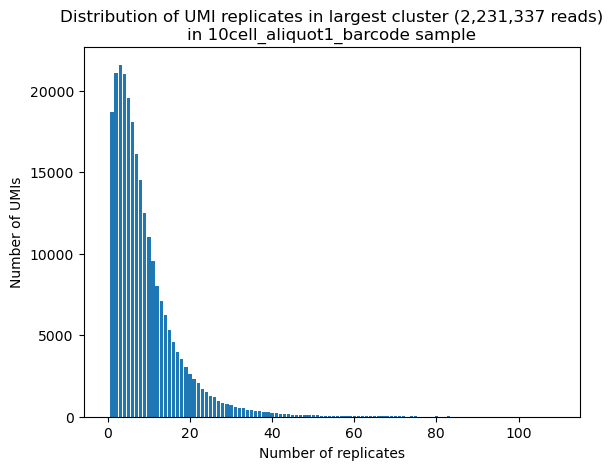

In [20]:
for barcode, cluster in all_clusters['10cell_aliquot1_barcode'].items():
    if sum(cluster.values()) == 2231337:
        plt.bar(np.arange(max(cluster.values())+1), np.bincount(list(cluster.values())))
        plt.xlabel('Number of replicates')
        plt.ylabel('Number of UMIs')
        plt.title('Distribution of UMI replicates in largest cluster (2,231,337 reads)\nin 10cell_aliquot1_barcode sample')
        break

# Recluster allowing for 1 tag substitution

Based on observation that most barcodes are within 1 tag substitution from largest cluster. Interpretation: Suboptimal SPRITE Zero ligation conditions (reactant concentrations, temperature, duration) --> many barcodes are not ligated with the latest tag before they are pooled with other barcodes and tags --> other tags can ligate the same barcode. Perhaps more likely to happen with R1, since that reaction is expected to take longer (Instant Sticky needs to enter cell nuclei).

In [39]:
df_barcodes = []
for sample in df_data['sample'].unique():
    path_mapping = os.path.join(dir_barcodes, f'{sample}.mapping')
    df_barcodes.append(
        pd.read_csv(path_mapping, sep='\s+', names=['tmp', 'barcode', 'count']) \
        .drop(columns='tmp') \
        .pipe(lambda df: pd.concat((df['barcode'].str.split(',', expand=True), df['count']), axis=1)) \
        .drop(columns=1).rename(columns={0: 'oligo', 2: 'R1', 3: 'R2', 4: 'R3', 5: 'Term'}) \
        .sort_values('count', ascending=False) \
        .assign(sample=sample))
df_barcodes = pd.concat(df_barcodes, axis=0, ignore_index=True)

In [40]:
df_barcodes_agg = df_barcodes.groupby(['R1', 'R2', 'R3', 'Term', 'sample'])['count'].sum().reset_index().sort_values(['sample', 'count'], ascending=False)

In [41]:
df_barcodes_agg.head()

,R1,R2,R3,Term,sample,count
76591,R1TopA24,R2TopB3,R3TopC12,NYLigOddStgTop_42,10cell_aliquot1_barcode,2231337
19787,R1TopA11,R2TopB3,R3TopC12,NYLigOddStgTop_42,10cell_aliquot1_barcode,36185
43676,R1TopA17,R2TopB3,R3TopC12,NYLigOddStgTop_42,10cell_aliquot1_barcode,33217
50760,R1TopA18,R2TopB3,R3TopC12,NYLigOddStgTop_42,10cell_aliquot1_barcode,30136
70229,R1TopA22,R2TopB3,R3TopC12,NYLigOddStgTop_42,10cell_aliquot1_barcode,28967


In [42]:
path_barcode_agg = os.path.join(DIR_AUX, 'barcode_agg.json')
if not os.path.exists(path_barcode_agg):
    barcode_to_barcode_agg = dict()
    for sample, group in df_barcodes_agg.groupby('sample'):
        print(sample)
        barcode_to_barcode_agg[sample] = dict()
        df_sorted = group.sort_values('count', ascending=False).assign(unclustered=True)
        df_sorted['barcode'] = '[' + df_sorted['R1'] + ']' + '[' + df_sorted['R2'] + ']' + '[' + df_sorted['R3'] + ']' + '[' + df_sorted['Term'] + ']'
        while df_sorted['unclustered'].any():
            s_cluster = df_sorted.loc[df_sorted['unclustered']].iloc[0]
            R1, R2, R3, Term = s_cluster[['R1', 'R2', 'R3', 'Term']]
            barcode_agg = s_cluster['barcode']
            mask_R1 = df_sorted['R1'] == R1
            mask_R2 = df_sorted['R2'] == R2
            mask_R3 = df_sorted['R3'] == R3
            mask_Term = df_sorted['Term'] == Term
            mask_cluster = \
                (mask_R1 & mask_R2 & mask_R3) | \
                (mask_R1 & mask_R2 & mask_Term) | \
                (mask_R1 & mask_Term & mask_R3) | \
                (mask_Term & mask_R2 & mask_R3)
            mask_cluster &= df_sorted['unclustered']
            barcode_to_barcode_agg[sample].update({barcode: barcode_agg for barcode in df_sorted.loc[mask_cluster, 'barcode']})
            df_sorted.loc[mask_cluster, 'unclustered'] = False
    with open(path_barcode_agg, 'wt') as f:
        json.dump(barcode_to_barcode_agg, f)
else:
    with open(path_barcode_agg, 'rt') as f:
        barcode_to_barcode_agg = json.load(f)

In [16]:
all_clusters_agg = dict()
for sample in df_data['sample'].unique():
    print(sample)
    path_barcoded = os.path.join(dir_barcodes, f'{sample}.fastq.gz')
    path_clusters = os.path.join(dir_clusters, f'{sample}_agg.json')
    if not os.path.exists(path_clusters):
        clusters = dict()
        with gzip.open(path_barcoded) as f:
            for (name, seq, _, qual) in tqdm(fastq_parse(f)):
                match = regex_readname.search(name.strip())
                if match:
                    barcode, umi = match.groups()
                barcode_agg = barcode_to_barcode_agg[sample][barcode]
                if barcode_agg not in clusters:
                    clusters[barcode_agg] = collections.defaultdict(int)
                clusters[barcode_agg][umi] += 1
        with open(path_clusters, 'wt') as f:
            json.dump(clusters, f)
    else:
        with open(path_clusters, 'rt') as f:
            clusters = json.load(f)
    all_clusters_agg[sample] = clusters

10cell_aliquot1_barcode
0-5cell_aliquotE9_barcode
0-15625cell_aliquot1_150bp
0-625cell_aliquot3_barcode
0-5cell_aliquotA6_barcode


In [18]:
cluster_agg_stats = dict()
for sample, clusters in all_clusters_agg.items():
    cluster_agg_stats[sample] = dict()
    cluster_agg_stats[sample]['cluster_sizes_dedup'] = np.array(list(map(len, clusters.values())))
    cluster_agg_stats[sample]['cluster_sizes'] = np.array([sum(cluster.values()) for cluster in clusters.values()])
    print(sample)
    print('Number of clusters:', len(cluster_agg_stats[sample]['cluster_sizes']))
    print('Size of largest clusters:', np.sort(cluster_agg_stats[sample]['cluster_sizes'])[-1:-10:-1])
    print('Size of largest clusters (dedup):', np.sort(cluster_agg_stats[sample]['cluster_sizes_dedup'])[-1:-10:-1])
    print()

10cell_aliquot1_barcode
Number of clusters: 5994
Size of largest clusters: [2680231   90429   82591   69090   47645   40252   37448   31637   28632]
Size of largest clusters (dedup): [252245  54593  51704  43616  31809  27573  25933  21914  20196]

0-5cell_aliquotE9_barcode
Number of clusters: 553
Size of largest clusters: [1801 1401  648  426  319  311  218  206  135]
Size of largest clusters (dedup): [1792 1389  647  425  319  310  217  206  134]

0-15625cell_aliquot1_150bp
Number of clusters: 40
Size of largest clusters: [10  2  1  1  1  1  1  1  1]
Size of largest clusters (dedup): [10  1  1  1  1  1  1  1  1]

0-625cell_aliquot3_barcode
Number of clusters: 3177
Size of largest clusters: [5499 3372 2825 1388  490  477  432  426  404]
Size of largest clusters (dedup): [4270 2647 2253 1088  385  378  337  336  317]

0-5cell_aliquotA6_barcode
Number of clusters: 120
Size of largest clusters: [1384  182  138  133   83   64   40   33   21]
Size of largest clusters (dedup): [1380  182  1

Even after reclustering, the main interpretation of the results is unchanged.

# Check identity of ~150 bp PCR product

See https://benchling.com/s/seq-ZfdqkzPO5jOEQQREG64L

In [46]:
template = 'AATGATACGGCGACCACCGAGATCTACACTCCATAACACACTCTTTCCCTACACGACGCTCTTCAGATCTGAAGAGCACACGTCTGAACTCCAGTCACCGCCTTCCATCTCGTATGCCGTCTTCTGCTTG'
template_rc = reverse_complement(template)
template_r1 = 'GAAGAGCACACGTCTGAACTCCAGTCACCGCCTTCCATCTCGTATGCCGTCTTCTGCTTG'
template_r2 = 'GAAGAGCGTCGTGTAGGGAAAGAGTGTGTTATGGAGTGTAGATCTCGGTGGTCGCCGTATCATT'
template_r2_rc = reverse_complement(template_r2)

In [47]:
path_r1 = os.path.join(DIR_DATA, '0-15625cell_aliquot1_150bp_S3_L001_R1_001.fastq.gz')
path_r2 = os.path.join(DIR_DATA, '0-15625cell_aliquot1_150bp_S3_L001_R2_001.fastq.gz')

Spot-check 10 read pairs

In [48]:
with gzip.open(path_r1) as f1, gzip.open(path_r2) as f2:
    for i, ((name1, seq1, _, _), (name2, seq2, _, _)) in enumerate(zip(fastq_parse(f1), fastq_parse(f2))):
        if i > 9:
            break
        assert name1.split()[0] == name2.split()[0]
        print(name1.split()[0])
        r1_align = pairwise2.align.globalxs(seq1, template, -1, -1, penalize_end_gaps=False)
        r2_align = pairwise2.align.globalxs(template, reverse_complement(seq2), -1, -1, penalize_end_gaps=False)
        print(pairwise2.format_alignment(*r1_align[0], full_sequences=True))
        print(pairwise2.format_alignment(*r2_align[0], full_sequences=True))

@M06105:68:000000000-KK7Y7:1:1101:14160:1074
----------------------------------------------------------------------GAAGAGCACACGTCTGAACTCCAGTCACCGCCTTCCATCTCGTTTGCCGTCTTCTGCTTGAAAAAAAAAAACTATAC
                                                                      |||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||                 
AATGATACGGCGACCACCGAGATCTACACTCCATAACACACTCTTTCCCTACACGACGCTCTTCAGATCTGAAGAGCACACGTCTGAACTCCAGTCACCGCCTTCCATCTCGTATGCCGTCTTCTGCTTG-----------------
  Score=59

------------AATGATACGGC-GACCACCGAGATCTACACTCCATAACACACTCTTTCCCTACACGACGCTCTTCAGATCTGAAGAGCACACGTCTGAACTCCAGTCACCGCCTTCCATCTCGTATGCCGTCTTCTGCTTG
            |||...||.|| |.||.|||..||.||||||||||||||||||||||||||||||||||||||||                                                                  
GTTTTTTTTATTAATTCCACCGCCGCCCCCCGCAATTTACACTCCATAACACACTCTTTCCCTACACGACGCTCTTC------------------------------------------------------------------
  Score=54

@M06105:68:000000000-KK7Y7:1:1101:14262:1114
----------

In [49]:
score_r1 = dict()
score_r2 = dict()
with gzip.open(path_r1) as f:
    n = len(template_r1)
    for name, seq, _, _ in tqdm(fastq_parse(f)):
        score_r1[name.split()[0]] = editdistance.eval(seq[:n], template_r1)
with gzip.open(path_r2) as f:
    n = len(template_r2)
    for name, seq, _, _ in tqdm(fastq_parse(f)):
        score_r2[name.split()[0]] = editdistance.eval(seq[:n], template_r2)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [50]:
df_eds = pd.concat((pd.Series(score_r1).rename('r1'), pd.Series(score_r2).rename('r2')), axis=1)
df_eds['both'] = df_eds['r1'] + df_eds['r2']

[Text(0.5, 0, 'Paired Edit Distance from Template')]

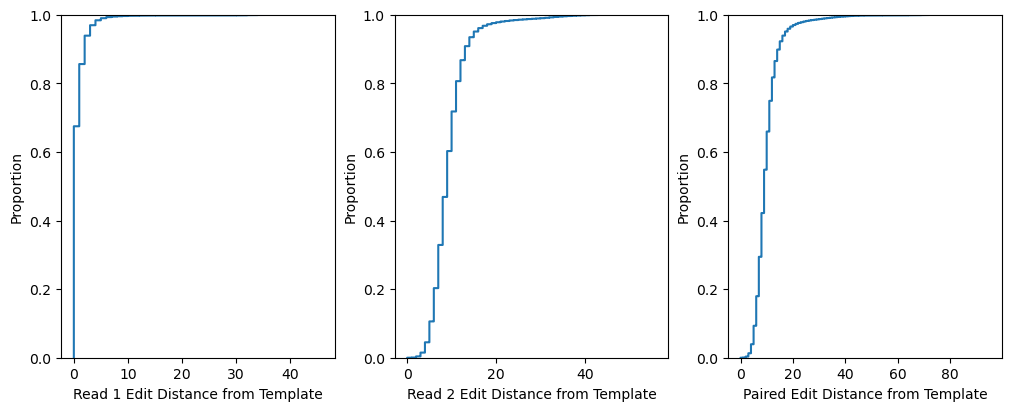

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
sns.ecdfplot(df_eds, x='r1', ax=axs[0])
axs[0].set(xlabel='Read 1 Edit Distance from Template')
sns.ecdfplot(df_eds, x='r2', ax=axs[1])
axs[1].set(xlabel='Read 2 Edit Distance from Template')
sns.ecdfplot(df_eds, x='both', ax=axs[2])
axs[2].set(xlabel='Paired Edit Distance from Template')

The really long edit distances presumably come from full barcodes, not the 130 bp primer dimer PCR product.

# Old code